In [2]:
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA

In [10]:
ranges=[] #cm
energies=[]

directory = '/sdf/data/neutrino/summer25/seohyeon/gampix_54k_raw/'
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
files = files[:10]


for filename in files:
    f = h5py.File(directory + filename)

    
    pixels = f['pixel_hits']
    tiles = f['coarse_hits']
    meta = f['meta']
    
    evs = meta['event id']
    
    for ev_n in evs:
        print('---------------------')
        print(f'event {ev_n}')
        ev_mask_pixels = pixels['event id'] == ev_n
        ev_pixels = pixels[ev_mask_pixels]
    
        
        #getting the coordinates of each hit
        coords = np.array([[hit['pixel x'], hit['pixel y'], hit['hit z']] for hit in ev_pixels])
        # print(f'number of pts: {len(coords)}')
    
        # pca analysis
        min_hits = 40
        if len(coords) < min_hits:
            print('skipped, not enough hits')
            continue
        else:
            pca = PCA(n_components = 3)
            pca_on_hits = pca.fit(coords)
            principal=pca.components_[0] #this is a unit vector
    
        
        if min(coords[:, 2]) < 5:
            print('skipped, too close to anode')
            continue
        
    
        KE = meta['primary energy'][ev_n]
        energies.append(KE)
    
    
        #getting projection of each hit onto the principal axis
        projections ={}
        for coord in coords:
            mag_proj = np.dot(principal, coord) #signed projection scalar
            projections[mag_proj] = coord
        
        track_length = max(projections) - min(projections)
        ranges.append(track_length)
        print(f'track length: {track_length}')


---------------------
event 0
skipped, too close to anode
---------------------
event 1


KeyboardInterrupt: 

[('event id', '<u4'), ('pixel x', '<f4'), ('pixel y', '<f4'), ('hit z', '<f4'), ('hit t', '<f4'), ('hit charge', '<f4')]


ModuleNotFoundError: No module named 'tools'

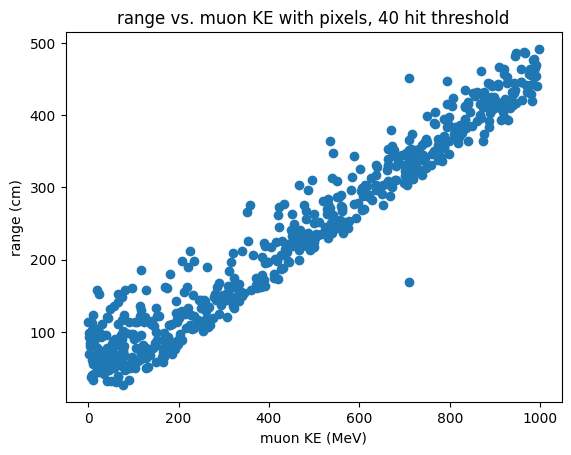

In [8]:
plt.figure()
plt.plot(energies, ranges, 'o')
plt.xlabel('muon KE (MeV)')
plt.ylabel('range (cm)')
plt.title(f'range vs. muon KE with pixels, {min_hits} hit threshold')
plt.savefig('naive_gampix_10k.png')


import importlib
import tools
importlib.reload(tools)
from tools import bin_data  

range_bin_midpts, range_avgs, range_rms, range_relative_rms = bin_data(energies, ranges, 20)
plt.figure()
plt.errorbar(range_bin_midpts, range_avgs, range_rms, fmt='o', label='edepsim')
plt.xlabel('muon kinetic energy (MeV)')
plt.ylabel('range (mm)')
plt.title(f'range vs. muon KE with pixels, {min_hits} hit threshold')
plt.savefig('naive_gampix_10k_profile.png')

plt.figure()
plt.hist2d(energies, ranges, bins=60)
plt.colorbar(label='Density')
plt.xlabel('muon kinetic energy (MeV)')
plt.ylabel('range (mm)')
plt.title(f'range vs. muon KE with pixels, {min_hits} hit threshold')
plt.savefig('naive_gampix_10k_hist.png')